# Game Tree Search

We start with defining the abstract class `Game`, for turn-taking *n*-player games. We rely on, but do not define yet, the concept of a `state` of the game; we'll see later how individual games define states. For now, all we require is that a state has a `state.to_move` attribute, which gives the name of the player whose turn it is. ("Name" will be something like `'X'` or `'O'` for tic-tac-toe.) 

We also define `play_game`, which takes a game and a dictionary of  `{player_name: strategy_function}` pairs, and plays out the game, on each turn checking `state.to_move` to see whose turn it is, and then getting the strategy function for that player and applying it to the game and the state to get a move.

In [1]:
from collections import namedtuple, Counter, defaultdict
import random
import math
import functools 
cache = functools.lru_cache(10**6)

In [2]:
cd/content/drive/MyDrive/Colab Notebooks/aima-python-master

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/aima-python-master'
/content


In [3]:
#@title Default title text1
class Game:
    """A game is similar to a problem, but it has a terminal test instead of 
    a goal test, and a utility for each terminal state. To create a game, 
    subclass this class and implement `actions`, `result`, `is_terminal`, 
    and `utility`. You will also need to set the .initial attribute to the 
    initial state; this can be done in the constructor."""

    def actions(self, state):
        """Return a collection of the allowable moves from this state."""
        raise NotImplementedError

    def result(self, state, move):
        """Return the state that results from making a move from a state."""
        raise NotImplementedError

    def is_terminal(self, state):
        """Return True if this is a final state for the game."""
        return not self.actions(state)
    
    def utility(self, state, player):
        """Return the value of this final state to player."""
        raise NotImplementedError
        

def play_game(game, strategies: dict, verbose=False):
    """Play a turn-taking game. `strategies` is a {player_name: function} dict,
    where function(state, game) is used to get the player's move."""
    state = game.initial
    while not game.is_terminal(state):
        player = state.to_move
        move = strategies[player](game, state)
        state = game.result(state, move)
        if verbose: 
            print('Player', player, 'move:', move)
            print(state)
    return state

# Minimax-Based Game Search Algorithms

We will define several game search algorithms. Each takes two inputs, the game we are playing and the current state of the game, and returns a a `(value, move)` pair, where `value` is the utility that the algorithm computes for the player whose turn it is to move, and `move` is the move itself.

First we define `minimax_search`, which exhaustively searches the game tree to find an optimal move (assuming both players play optimally), and `alphabeta_search`, which does the same computation, but prunes parts of the tree that could not possibly have an affect on the optimnal move.  

In [4]:
def minimax_search(game, state):
    """Search game tree to determine best move; return (value, move) pair."""

    player = state.to_move

    def max_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a))
            if v2 > v:
                v, move = v2, a
        return v, move

    def min_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a))
            if v2 < v:
                v, move = v2, a
        return v, move

    return max_value(state)

infinity = math.inf

def alphabeta_search(game, state):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = state.to_move

    def max_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    def min_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -infinity, +infinity)

# A Simple Game: Tic-Tac-Toe

We have the notion of an abstract game, we have some search functions; now it is time to define a real game; a simple one, tic-tac-toe. Moves are `(x, y)` pairs denoting squares, where `(0, 0)` is the top left, and `(2, 2)` is the bottom right (on a board of size `height=width=3`).

In [5]:
class TicTacToe(Game):
    """Play TicTacToe on an `height` by `width` board, needing `k` in a row to win.
    'X' plays first against 'O'."""

    def __init__(self, height=3, width=3, k=3):
        self.k = k # k in a row
        self.squares = {(x, y) for x in range(width) for y in range(height)}
        self.initial = Board(height=height, width=width, to_move='X', utility=0)

    def actions(self, board):
        """Legal moves are any square not yet taken."""
        return self.squares - set(board)

    def result(self, board, square):
        """Place a marker for current player on square."""
        player = board.to_move
        board = board.new({square: player}, to_move=('O' if player == 'X' else 'X'))
        win = k_in_row(board, player, square, self.k)
        board.utility = (0 if not win else +1 if player == 'X' else -1)
        return board

    def utility(self, board, player):
        """Return the value to player; 1 for win, -1 for loss, 0 otherwise."""
        return board.utility if player == 'X' else -board.utility

    def is_terminal(self, board):
        """A board is a terminal state if it is won or there are no empty squares."""
        return board.utility != 0 or len(self.squares) == len(board)

    def display(self, board): print(board)     


def k_in_row(board, player, square, k):
    """True if player has k pieces in a line through square."""
    def in_row(x, y, dx, dy): return 0 if board[x, y] != player else 1 + in_row(x + dx, y + dy, dx, dy)
    return any(in_row(*square, dx, dy) + in_row(*square, -dx, -dy) - 1 >= k
               for (dx, dy) in ((0, 1), (1, 0), (1, 1), (1, -1)))

States in tic-tac-toe (and other games) will be represented as a `Board`, which is a subclass of `defaultdict` that in general will consist of `{(x, y): contents}` pairs, for example `{(0, 0): 'X', (1, 1): 'O'}` might be the state of the board after two moves. Besides the contents of squares, a board also has some attributes: 
- `.to_move` to name the player whose move it is; 
- `.width` and `.height` to give the size of the board (both 3 in tic-tac-toe, but other numbers in related games);
- possibly other attributes, as specified by keywords. 

As a `defaultdict`, the `Board` class has a `__missing__` method, which returns `empty` for squares that have no been assigned but are within the `width` × `height` boundaries, or `off` otherwise. The class has a `__hash__` method, so instances can be stored in hash tables.

In [6]:
class Board(defaultdict):
    """A board has the player to move, a cached utility value, 
    and a dict of {(x, y): player} entries, where player is 'X' or 'O'."""
    empty = '.'
    off = '#'
    
    def __init__(self, width=8, height=8, to_move=None, **kwds):
        self.__dict__.update(width=width, height=height, to_move=to_move, **kwds)
        
    def new(self, changes: dict, **kwds) -> 'Board':
        "Given a dict of {(x, y): contents} changes, return a new Board with the changes."
        board = Board(width=self.width, height=self.height, **kwds)
        board.update(self)
        board.update(changes)
        return board

    def __missing__(self, loc):
        x, y = loc
        if 0 <= x < self.width and 0 <= y < self.height:
            return self.empty
        else:
            return self.off
            
    def __hash__(self): 
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)
    
    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(map(row, range(self.height))) +  '\n'

# Players

We need an interface for players. I'll represent a player as a `callable` that will be passed two arguments: `(game, state)` and will return a `move`.
The function `player` creates a player out of a search algorithm, but you can create your own players as functions, as is done with `random_player` below:

In [7]:
def random_player(game, state): 
  return random.choice(list(game.actions(state)))
  
 

def player(search_algorithm):
    """A game player who uses the specified search algorithm"""
    return lambda game, state: search_algorithm(game, state)[1]

# Playing a Game

We're ready to play a game. I'll set up a match between a `random_player` (who chooses randomly from the legal moves) and a `player(alphabeta_search)` (who makes the optimal alpha-beta move; practical for tic-tac-toe, but not for large games). The `player(alphabeta_search)` will never lose, but if `random_player` is lucky, it will be a tie.

In [8]:
play_game(TicTacToe(), dict(X=random_player, O=player(alphabeta_search)), verbose=True).utility

Player X move: (2, 0)
. . X
. . .
. . .

Player O move: (1, 1)
. . X
. O .
. . .

Player X move: (1, 2)
. . X
. O .
. X .

Player O move: (0, 1)
. . X
O O .
. X .

Player X move: (2, 1)
. . X
O O X
. X .

Player O move: (2, 2)
. . X
O O X
. X O

Player X move: (1, 0)
. X X
O O X
. X O

Player O move: (0, 0)
O X X
O O X
. X O



-1

The alpha-beta player will never lose, but sometimes the random player can stumble into a draw. When two optimal (alpha-beta or minimax) players compete, it will always be a draw:

In [9]:
play_game(TicTacToe(), dict(X=player(alphabeta_search), O=player(minimax_search)), verbose=True).utility

Player X move: (0, 1)
. . .
X . .
. . .

Player O move: (0, 0)
O . .
X . .
. . .

Player X move: (2, 0)
O . X
X . .
. . .

Player O move: (2, 1)
O . X
X . O
. . .

Player X move: (1, 2)
O . X
X . O
. X .

Player O move: (0, 2)
O . X
X . O
O X .

Player X move: (1, 0)
O X X
X . O
O X .

Player O move: (1, 1)
O X X
X O O
O X .

Player X move: (2, 2)
O X X
X O O
O X X



0

# Connect Four

Connect Four is a variant of tic-tac-toe, played on a larger (7 x 6) board, and with the restriction that in any column you can only play in the lowest empty square in the column.

In [10]:
class ConnectFour(TicTacToe):
    
    def __init__(self): super().__init__(width=7, height=6, k=4)

    def actions(self, board):
        """In each column you can play only the lowest empty square in the column."""
        return {(x, y) for (x, y) in self.squares - set(board)
                if y == board.height - 1 or (x, y + 1) in board}

In [11]:
play_game(ConnectFour(), dict(X=random_player, O=random_player), verbose=True).utility

Player X move: (5, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X .

Player O move: (1, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. O . . . X .

Player X move: (6, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. O . . . X X

Player O move: (6, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . O
. O . . . X X

Player X move: (0, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . O
X O . . . X X

Player O move: (1, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. O . . . . O
X O . . . X X

Player X move: (1, 3)
. . . . . . .
. . . . . . .
. . . . . . .
. X . . . . .
. O . . . . O
X O . . . X X

Player O move: (1, 2)
. . . . . . .
. . . . . . .
. O . . . . .
. X . . . . .
. O . . . . O
X O . . . X X

Player X move: (5, 4)
. . . . . . .
. . . . . . .
. O . . . . .
. X . . . . .
. O . . . X O
X O . . . X X

Player O move: (4, 5)
. . . . . . .
.

-1

**Transposition Tables** 

A transposition table is a cache of previously seen positions, and associated evaluations, in a game tree generated by a computer game playing program.

By treating the game tree as a tree, we can arrive at the same state through different paths, and end up duplicating effort. In state-space search, we kept a table of reached states to prevent this. For game-tree search, we can achieve the same effect by applying the @cache decorator to the min_value and max_value functions. We'll use the suffix _tt to indicate a function that uses these transisiton tables.

In [12]:
def minimax_search_tt(game, state):
    """Search game to determine best move; return (value, move) pair."""

    player = state.to_move

    @cache
    def max_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a))
            if v2 > v:
                v, move = v2, a
        return v, move

    @cache
    def min_value(state):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a))
            if v2 < v:
                v, move = v2, a
        return v, move

    return max_value(state)

In [13]:
def cache1(function):
    "Like lru_cache(None), but only considers the first argument of function."
    cache = {}
    def wrapped(x, *args):
        if x not in cache:
            cache[x] = function(x, *args)
        return cache[x]
    return wrapped

def alphabeta_search_tt(game, state):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = state.to_move

    @cache1
    def max_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    @cache1
    def min_value(state, alpha, beta):
        if game.is_terminal(state):
            return game.utility(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -infinity, +infinity)

In [14]:
%time play_game(TicTacToe(), {'X':player(alphabeta_search_tt), 'O':player(minimax_search_tt)})

CPU times: user 282 ms, sys: 4.83 ms, total: 287 ms
Wall time: 289 ms


Board(None,
      {(0, 0): 'O',
       (0, 1): 'X',
       (0, 2): 'O',
       (1, 0): 'X',
       (1, 1): 'O',
       (1, 2): 'X',
       (2, 0): 'X',
       (2, 1): 'O',
       (2, 2): 'X'})

In [15]:
%time play_game(TicTacToe(), {'X':player(alphabeta_search), 'O':player(minimax_search)})

CPU times: user 1.48 s, sys: 3.93 ms, total: 1.48 s
Wall time: 1.49 s


Board(None,
      {(0, 0): 'O',
       (0, 1): 'X',
       (0, 2): 'O',
       (1, 0): 'X',
       (1, 1): 'O',
       (1, 2): 'X',
       (2, 0): 'X',
       (2, 1): 'O',
       (2, 2): 'X'})

**Heuristic Cutoffs**

In [16]:
def cutoff_depth(d):
    """A cutoff function that searches to depth d."""
    return lambda game, state, depth: depth > d

def h_alphabeta_search(game, state, cutoff=cutoff_depth(6), h=lambda s, p: 0):
    """Search game to determine best action; use alpha-beta pruning.
    As in [Figure 5.7], this version searches all the way to the leaves."""

    player = state.to_move

    @cache1
    def max_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return h(state, player), None
        v, move = -infinity, None
        for a in game.actions(state):
            v2, _ = min_value(game.result(state, a), alpha, beta, depth+1)
            if v2 > v:
                v, move = v2, a
                alpha = max(alpha, v)
            if v >= beta:
                return v, move
        return v, move

    @cache1
    def min_value(state, alpha, beta, depth):
        if game.is_terminal(state):
            return game.utility(state, player), None
        if cutoff(game, state, depth):
            return h(state, player), None
        v, move = +infinity, None
        for a in game.actions(state):
            v2, _ = max_value(game.result(state, a), alpha, beta, depth + 1)
            if v2 < v:
                v, move = v2, a
                beta = min(beta, v)
            if v <= alpha:
                return v, move
        return v, move

    return max_value(state, -infinity, +infinity, 0)

In [17]:
%time play_game(TicTacToe(), {'X':player(h_alphabeta_search), 'O':player(h_alphabeta_search)})

CPU times: user 191 ms, sys: 3.1 ms, total: 194 ms
Wall time: 196 ms


Board(None,
      {(0, 0): 'O',
       (0, 1): 'X',
       (0, 2): 'O',
       (1, 0): 'X',
       (1, 1): 'O',
       (1, 2): 'X',
       (2, 0): 'X',
       (2, 1): 'O',
       (2, 2): 'X'})

In [18]:
%time play_game(ConnectFour(), {'X':player(h_alphabeta_search), 'O':random_player}, verbose=True).utility

Player X move: (5, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X .

Player O move: (4, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . O X .

Player X move: (5, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X .
. . . . O X .

Player O move: (3, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X .
. . . O O X .

Player X move: (4, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . X X .
. . . O O X .

Player O move: (4, 3)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . O . .
. . . . X X .
. . . O O X .

Player X move: (1, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . O . .
. . . . X X .
. X . O O X .

Player O move: (0, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . O . .
. . . . X X .
O X . O O X .

Player X move: (1, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . O . .
. X . . X X .
O X . O O X .

Player O move: (2, 5)
. . . . . . .
.

1

In [19]:
%time play_game(ConnectFour(), {'X':player(h_alphabeta_search), 'O':player(h_alphabeta_search)}, verbose=True).utility

Player X move: (5, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . X .

Player O move: (5, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . O .
. . . . . X .

Player X move: (4, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . O .
. . . . X X .

Player O move: (2, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . O .
. . O . X X .

Player X move: (4, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . X O .
. . O . X X .

Player O move: (3, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . X O .
. . O O X X .

Player X move: (1, 5)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. . . . X O .
. X O O X X .

Player O move: (1, 4)
. . . . . . .
. . . . . . .
. . . . . . .
. . . . . . .
. O . . X O .
. X O O X X .

Player X move: (1, 3)
. . . . . . .
. . . . . . .
. . . . . . .
. X . . . . .
. O . . X O .
. X O O X X .

Player O move: (1, 2)
. . . . . . .
.

1

In [20]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()
        
    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)
    
def report(game, searchers):
    for searcher in searchers:
        game = CountCalls(game)
        searcher(game, game.initial)
        print('Result states: {:7,d}; Terminal tests: {:7,d}; for {}'.format(
            game._counts['result'], game._counts['is_terminal'], searcher.__name__))
    
report(TicTacToe(), (alphabeta_search_tt,  alphabeta_search, h_alphabeta_search, minimax_search_tt))

Result states:   6,589; Terminal tests:   3,653; for alphabeta_search_tt
Result states:  25,703; Terminal tests:  25,704; for alphabeta_search
Result states:   4,687; Terminal tests:   2,805; for h_alphabeta_search
Result states:  16,167; Terminal tests:   5,478; for minimax_search_tt


# TASKS

**Task 1 [30%]**

1) Create a game called Tic-tac-toe by implementing the minimax search algorithm and follow the rules stated below:

*   Initially the board should be blank with two opposed player, MAX and MIN.
*   The program should be the MAX player and the program will choose its action and you will be the MIN player and its actions will be put via keyboard input.

*   Your code should specify the best move and position for the MIN player.
*   It will have 3 values terminal state utilities:

> -1 if player that seeks minimum wins

> 0 if it's a tie

> 1 if player that seeks maximum wins

*   After each MAX action, you must display the current board configuration and clear directions to the keyboard user (MIN) indicating how to enter an action. 
*  You will denote MAX’s action as X and MIN’s action as O.
*   After the code execution, the output should display:

> A case in which MAX wins

> A case in which MIN wins (Can be omitted with explanation)

> A case in which there is a tie


In [22]:
def MIN(game, state): 
   a=list(game.actions(state))
   print(a)
   b = int(input())
   return a[b]
  
def player(search_algorithm):
    """A game player who uses the specified search algorithm"""
    return lambda game, state: search_algorithm(game, state)[1]

In [24]:
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(minimax_search)), verbose=True).utility

Two Players Max and Min Were playing the game the Symbol of Max is X and Symbol of Min is O
[(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
1
Player X move: (1, 2)
. . .
. . .
. X .

Player O move: (1, 1)
. . .
. O .
. X .

[(0, 1), (0, 0), (2, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
3
Player X move: (2, 0)
. . X
. O .
. X .

Player O move: (0, 1)
. . X
O O .
. X .

[(0, 0), (2, 1), (2, 2), (1, 0), (0, 2)]
4
Player X move: (0, 2)
. . X
O O .
X X .

Player O move: (2, 1)
. . X
O O O
X X .



-1

In [32]:
# two players playing game of max x with 0
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(minimax_search)), verbose=True).utility

Two Players Max and Min Were playing the game the Symbol of Max is X and Symbol of Min is O
[(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
5
Player X move: (1, 1)
. . .
. X .
. . .

Player O move: (0, 0)
O . .
. X .
. . .

[(0, 1), (1, 2), (2, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
2
Player X move: (2, 1)
O . .
. X X
. . .

Player O move: (0, 1)
O . .
O X X
. . .

[(1, 2), (2, 0), (2, 2), (1, 0), (0, 2)]
4
Player X move: (0, 2)
O . .
O X X
X . .

Player O move: (2, 0)
O . O
O X X
X . .

[(1, 2), (1, 0), (2, 2)]
1
Player X move: (1, 0)
O X O
O X X
X . .

Player O move: (1, 2)
O X O
O X X
X O .

[(2, 2)]
-0
Player X move: (2, 2)
O X O
O X X
X O X



0

In [35]:
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(minimax_search)), verbose=True).utility

Two Players Max and Min Were playing the game the Symbol of Max is X and Symbol of Min is O
[(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
5
Player X move: (1, 1)
. . .
. X .
. . .

Player O move: (0, 0)
O . .
. X .
. . .

[(0, 1), (1, 2), (2, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
0
Player X move: (0, 1)
O . .
X X .
. . .

Player O move: (2, 1)
O . .
X X O
. . .

[(1, 2), (2, 0), (2, 2), (1, 0), (0, 2)]
0
Player X move: (1, 2)
O . .
X X O
. X .

Player O move: (1, 0)
O O .
X X O
. X .

[(2, 0), (0, 2), (2, 2)]
0
Player X move: (2, 0)
O O X
X X O
. X .

Player O move: (0, 2)
O O X
X X O
O X .

[(2, 2)]
0
Player X move: (2, 2)
O O X
X X O
O X X



0

**Task 2 [30%]**

2) Now create the same Tic-tac-toe game and add alpha-beta search algorithm to prune it and follow the rules below:

*   Initially the board should be blank with two opposed player, MAX and MIN.
*   The program should be the MAX player and the program will choose its action and you will be the MIN player and its actions will be put via keyboard input.

*   Your code should specify the best move and position for the MIN player.
*   It will have 3 values terminal state utilities:

> -1 if player that seeks minimum wins

> 0 if it's a tie

> 1 if player that seeks maximum wins

*   After each MAX action, you must display the current board configuration and clear directions to the keyboard user (MIN) indicating how to enter an action. 
*  You will denote MAX’s action as X and MIN’s action as O.
*   After the code execution, the output should display:

> A case in which MAX wins

> A case in which MIN wins (Can be omitted with explanation)

> A case in which there is a tie


In [23]:
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(alphabeta_search)), verbose=True).utility

Two Players Max and Min are playing the game
The Symbol of Max = X & Symbol of Min = O
[(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
5
Player X move: (1, 1)
. . .
. X .
. . .

Player O move: (0, 0)
O . .
. X .
. . .

[(0, 1), (1, 2), (2, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
0
Player X move: (0, 1)
O . .
X X .
. . .

Player O move: (2, 1)
O . .
X X O
. . .

[(1, 2), (2, 0), (2, 2), (1, 0), (0, 2)]
0
Player X move: (1, 2)
O . .
X X O
. X .

Player O move: (1, 0)
O O .
X X O
. X .

[(2, 0), (0, 2), (2, 2)]
0
Player X move: (2, 0)
O O X
X X O
. X .

Player O move: (0, 2)
O O X
X X O
O X .

[(2, 2)]
0
Player X move: (2, 2)
O O X
X X O
O X X



0

In [ ]:
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(alphabeta_search)), verbose=True).utility

In [30]:
print("Two Players Max and Min are playing the game")
print("The Symbol of Max = X & Symbol of Min = O")
play_game(TicTacToe(), dict(X=MIN, O=player(alphabeta_search)), verbose=True).utility

Two Players Max and Min Were playing the game the Symbol of Max is X and Symbol of Min is O
[(0, 1), (1, 2), (0, 0), (2, 1), (2, 0), (1, 1), (2, 2), (1, 0), (0, 2)]
2
Player X move: (0, 0)
X . .
. . .
. . .

Player O move: (1, 1)
X . .
. O .
. . .

[(0, 1), (1, 2), (2, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
2
Player X move: (2, 1)
X . .
. O X
. . .

Player O move: (1, 2)
X . .
. O X
. O .

[(0, 1), (2, 0), (2, 2), (1, 0), (0, 2)]
2
Player X move: (2, 2)
X . .
. O X
. O X

Player O move: (2, 0)
X . O
. O X
. O X

[(0, 1), (1, 0), (0, 2)]
0
Player X move: (0, 1)
X . O
X O X
. O X

Player O move: (1, 0)
X O O
X O X
. O X



-1

**Task 3 [10%]**

3) Explain the shortest and the longest time takes for each execution in Q1 and Q2, and compare them. Explain time taken the steps needed to reach the terminal state.

**Task 4 [30%]**

* Given a set of values, v = [2, 3, 5, 9, 0, 1, 7, 5]  
* Define the Initial values of Alpha and Beta in your code 
* Print the optimal value for the current player using alpha-beta pruning algorithm. 
* In a separate paper, show the whole process of the pruning of the tree and show which branches are being cut off. Add the final node (A-G) values at each level. Your calculation of the optimal value should match with the optimal value of your code. 
* Mention the time taken to reach the optimal value in the code.

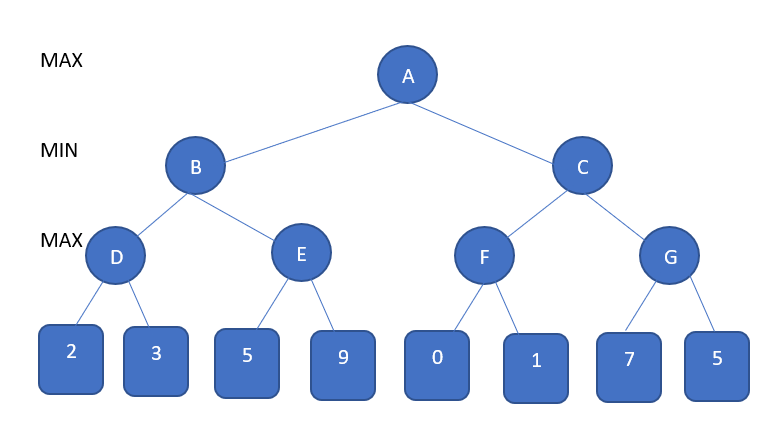










**Report**

The report should include a clear description of the code run in task 1, 2.

Answer Question 3 in a clear and brief manner.

It should also include the screenshots of the code outputs.

For task 4, you may use pen-paper or draw using paint on your computer to illustrate the pruning of the tree and show which branches are being cut off after applying alpha-beta pruning.

